In [47]:
import numpy as np
import tensorflow as tf
import keras
import SimpleITK as sitk
import vtk
import itk
import os
import matplotlib.pyplot as plt
from scipy.misc import imresize

def read_DICOM(dir_path):
    'Read DICOM image from directory'
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( dir_path )
    if len(dicom_names) > 0:
        reader.SetFileNames(dicom_names)
        image = reader.Execute()
        return image
    else:
        return None

def read_DICOMs(rootdir):
    'Read all DICOMs in a directory tree'
    images = list()
    for root, subFolders, files in os.walk(rootdir):
        for subf in subFolders:
            try:
                dir_path = os.path.join(root, subf)
                image = read_DICOM(dir_path=dir_path)
                # if image:
                #    print("Read {}".format(dir_path))
            except:
                pass
                # print("Error reading {}".format(dir_path))
            if image:
                im_array = sitk.GetArrayFromImage(image)
                images.append(im_array)
    return images

def show_slice(im, axis=1, fract=2):
    'Show slice along axis at faction of slice'
    idx = int(im.shape[axis]/2)
    if axis == 0:
        im_slice = im[idx, :, :]
    elif axis == 1:
        im_slice = im[:, idx, :]
    elif axis == 2:
        im_slice = im[:, :, idx]
    else:
        im_slice = im[idx, :, :]
        
    plt.imshow(im_slice, cmap='gray')
    

In [43]:
kich_kidney = read_DICOMs(rootdir='/home/ktdiedrich/Documents/localData/RadiologyImages/TCGAkidney/TCGA-KICH')
print("KICH_kidney N={}".format(len(kich_kidney)))

KICH_kidney N=107


In [44]:
prostate = read_DICOMs(rootdir='/home/ktdiedrich/Documents/localData/RadiologyImages/ProstateFusedMRIPathology')
print("Prostate N={}".format(len(prostate)))

Prostate N=207


In [50]:
label_name = dict()
label_name[0] = "KICH Kidney"
label_name[1] = "Prostate"
kich_labels = [0] * len(kich_kidney)
prostate_labels = [1] * len(prostate)

kich_kidney[0] shape=(81, 512, 512)
prostate[0] shape=(350, 512, 512)


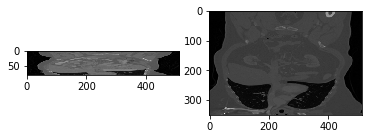

In [49]:
print("kich_kidney[0] shape={}".format(kich_kidney[0].shape))
print("prostate[0] shape={}".format(prostate[0].shape))
plt.subplot(1, 2, 1)
show_slice(im=kich_kidney[0], axis=1)
plt.subplot(1, 2, 2)
show_slice(im=prostate[0], axis=1)